In [1]:
import lal
import pycbc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import lalsimulation
from pycbc.waveform.utils import taper_timeseries

plt.style.use('default')
plt.rcParams.update({"text.usetex": True,
    "font.family": "sans-serif",
    "axes.formatter.use_mathtext": True
})

In [2]:
delta_f = 1/8
duration = 8
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 1024
sampling_frequency = 2048

In [10]:
import lal
import numpy as np
from pesummary.io import read
import lalinference.imrtgr.nrutils as nr

# Constants
G_SI = lal.G_SI  #6.67430*1e-11 
c_SI = lal.C_SI  #299792458. 
Msun_SI = lal.MSUN_SI  #1.989*1e30

def remnant_prms_estimate(m1, m2, a1=0., a2=0., tilt1=0., tilt2=0., phi12=0.):
    """
    Returns the mass and spin of the final remnant based on initial binary configuration.

    Parameters
    ----------
    m1 : float or numpy.array
        The mass of the first component object in the binary (in solar masses).
    m2 : float or numpy.array
        The mass of the second component object in the binary (in solar masses).
    a1 : float, optional
        The dimensionless spin magnitude of the first binary component. Default = 0.
    a2 : float, optional
        The dimensionless spin magnitude of the second binary component. Default = 0.
    tilt1 : float, optional
        Zenith angle between S1 and LNhat (rad). Default = 0.
    tilt2 : float, optional
        Zenith angle between S2 and LNhat (rad). Default = 0.
    phi12 : float, optional
        Difference in azimuthal angle between S1 and S2 (rad). Default = 0.

    Returns
    -------
    dict: 
        Dictionary of:

        * m_f: float
            Final mass of the remnant (in solar masses).
        * a_f: float
            Final dimensionless spin of the remnant.    

    """        
            
    # Use the following final mass and spin fits to calculate fISCO
    Mf_fits = ["UIB2016", "HL2016"]
    af_fits = ["UIB2016", "HL2016", "HBR2016"]

    # Final mass computation does not use phi12, so we set it to zero
    Mf = nr.bbh_average_fits_precessing(
        m1,
        m2,
        a1,
        a2,
        tilt1,
        tilt2,
        phi12=np.array([0.0]),
        quantity="Mf",
        fits=Mf_fits,
    )
    af = nr.bbh_average_fits_precessing(
        m1, m2, a1, a2, tilt1, tilt2, phi12=phi12, quantity="af", fits=af_fits
    )
    return dict(m_f=float(Mf), a_f=float(af))

def r_ISCO(m_tot, a_f):
    """
    Returns the equatorial Innermost Stable Circular Orbit (ISCO), also known as radius of the marginally stable orbit. For Kerr metric, it depends on 
    whether the orbit is prograde (negative sign) or retrograde (positive sign).
    References: 
    Eq.2.21 of _Bardeen et al. <https://ui.adsabs.harvard.edu/abs/1972ApJ...178..347B/abstract>_,
    Eq.1 of _Chad Hanna et al. <https://arxiv.org/pdf/0801.4297.pdf>_
    
    Parameters
    ----------
    m_tot = m1+m2 : float
        Binary mass (in solar masses).
    a_f : float
        Dimensionless spin parameter of the remnant compact object.

    Returns
    -------
    dict: 
        Dictionary of:

        * R_ISCO_retrograde: float
            ISCO radius for a particle in retrogade motion (in solar masses).

    """

    fac = m_tot
    z1 = 1 + np.cbrt(1 - a_f**2)*(np.cbrt(1 + a_f) + np.cbrt(1 - a_f))
    z2 = np.sqrt(3*a_f**2 + z1**2)
    risco_n = fac*(3 + z2 - np.sqrt((3 - z1)*(3 + z1 + 2*z2)))
    risco_p = fac*(3 + z2 + np.sqrt((3 - z1)*(3 + z1 + 2*z2)))
    r_dict = dict(R_ISCO_retrograde=risco_p, R_ISCO_prograde=risco_n)
    return r_dict

def f_GW_Kerr_ISCO(m_tot, a_f):         
    """
    Returns GW frequency at ISCO for a spinning BH Binary.
    References: Eq.4 of `Chad Hanna et al. <https://arxiv.org/pdf/0801.4297.pdf>`

    Parameters
    ----------
    m_tot=m1+m2 : float
        Binary Mass (in solar masses).
    a_f : float
        Final dimensionless spin magnitude of the remnant.

    Returns
    -------
    dict: 
        Dictionary of:

        * f_ISCO_retrograde: float
            GW frequency at ISCO for binaries in retrogade motion (in solar masses).
        * f_ISCO_prograde: float
            ISCO radius for a particle in prograde motion (in solar masses).  
                
    """     

    fac = c_SI**3/(2*np.pi*G_SI*m_tot*Msun_SI)
    r_res = r_ISCO(m_tot, a_f)
    r_n = r_res['R_ISCO_prograde']
    r_p = r_res['R_ISCO_retrograde']
    f_orb_isco_n = fac*(a_f + pow(r_n/m_tot, 3/2))**(-1)
    f_orb_isco_p = fac*(a_f + pow(r_p/m_tot, 3/2))**(-1)
    f_n, f_p = 2*f_orb_isco_n, 2*f_orb_isco_p    # because of quadrupolar contributions, f_gw = 2 * f_orb
    f_dict = dict(f_ISCO_retrograde=f_p, f_ISCO_prograde=f_n)
    return f_dict

In [3]:

def jframe_to_l0frame(mass_1, mass_2, f_ref, phi_ref=0., theta_jn=0., phi_jl=0., a_1=0., a_2=0., tilt_1=0., tilt_2=0., phi_12=0., **kwargs):  
    """
    [Inherited from PyCBC and lalsimulation.]
        Function to convert J-frame coordinates (which Bilby uses for PE) to L0-frame coordinates (that Pycbc uses for waveform generation).
        J stands for the total angular momentum while L0 stands for the orbital angular momentum.
    """ 

    inclination, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = \
        lalsimulation.SimInspiralTransformPrecessingNewInitialConditions(
            theta_jn, phi_jl, tilt_1, tilt_2, phi_12,
            a_1, a_2, mass_1*lal.MSUN_SI, mass_2*lal.MSUN_SI, f_ref,
            phi_ref)
    out_dict = {'inclination': inclination,
                'spin1x': spin1x,
                'spin1y': spin1y,
                'spin1z': spin1z,
                'spin2x': spin2x,
                'spin2y': spin2y,
                'spin2z': spin2z}
    return out_dict

In [4]:
def inject_wf(injection_parameters):
    """
    Generate PyCBC time domain SINGLES waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors
    """

    lframe = jframe_to_l0frame(mass_1=injection_parameters['mass_1'], 
                               mass_2=injection_parameters['mass_2'], 
                               f_ref=reference_frequency, 
                               theta_jn=injection_parameters['theta_jn'], 
                               phi_jl=injection_parameters['phi_jl'], 
                               a_1=injection_parameters['a_1'], 
                               a_2=injection_parameters['a_2'], 
                               tilt_1=injection_parameters['tilt_1'], 
                               tilt_2=injection_parameters['tilt_2'], 
                               phi_12=injection_parameters['phi_12'])    

    waveform_params = {
        'approximant': 'IMRPhenomXPHM',
        'mass1': injection_parameters['mass_1'],
        'mass2': injection_parameters['mass_2'],
        'spin1x': lframe['spin1x'],
        'spin1y': lframe['spin1y'],
        'spin1z': lframe['spin1z'],
        'spin2x': lframe['spin2x'],
        'spin2y': lframe['spin2y'],
        'spin2z': lframe['spin2z'],
        'distance': injection_parameters['luminosity_distance'],
        'inclination': lframe['inclination'],
        'coa_phase': injection_parameters['phase'],
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': 1 / sampling_frequency,
        'mode_array': injection_parameters['mode_array']
    }

    hp, hc = pycbc.waveform.get_td_waveform(**waveform_params)
    hp.start_time += injection_parameters['geocent_time']
    hc.start_time += injection_parameters['geocent_time']

    det, ifo_signal = dict(), dict()
    for ifo in ['H1', 'L1', 'V1']:
        det[ifo] = pycbc.detector.Detector(ifo)
        ifo_signal[ifo] = det[ifo].project_wave(hp, hc, injection_parameters['ra'], injection_parameters['dec'], injection_parameters['psi'])
        ifo_signal[ifo] = taper_timeseries(ifo_signal[ifo], tapermethod='TAPER_STARTEND', return_lal=False)

    ht_H1, ht_L1, ht_V1 = ifo_signal['H1'], ifo_signal['L1'], ifo_signal['V1']

    return ht_H1, ht_L1, ht_V1

In [14]:
ht_H1, ht_L1, ht_V1, f_isco = {}, {}, {}, {}
mode_array = [None, [(2, 2)], [(3, 3)], [(4, 4)]]
for idx, mode in enumerate(mode_array):
    injection_parameters = {'mass_1': 7, 
                            'mass_2': 50, 
                            'luminosity_distance': 600, 
                            'a_1': 0.5, 
                            'a_2': 0.35, 
                            'tilt_1': 0.1, 
                            'tilt_2': 0.1, 
                            'theta_jn': 0.1, 
                            'phi_12': 1.3264568220000164, 
                            'phi_jl': 4.3767796519003026, 
                            'ra': -0.2231247386804483, 
                            'dec': 0.1839772515975745, 
                            'psi': 1.649825290199503, 
                            'phase': 1.3371755312430611, 
                            'incl': 2, 
                            'geocent_time': 0,
                            'mode_array': mode}
    
    res = remnant_prms_estimate(injection_parameters['mass_1'], injection_parameters['mass_2'], a1=injection_parameters['a_1'], a2=injection_parameters['a_2'], tilt1=injection_parameters['tilt_1'], tilt2=injection_parameters['tilt_2'], phi12=injection_parameters['phi_12'])
    
    if mode is None:
        htf_H1, htf_L1, htf_V1 = inject_wf(injection_parameters)
        ff_isco =  f_GW_Kerr_ISCO(injection_parameters['mass_1']+injection_parameters['mass_2'], res['a_f'])['f_ISCO_prograde']
    else:
        ht_H1[f"{mode}"], ht_L1[f"{mode}"], ht_V1[f"{mode}"] = inject_wf(injection_parameters)
        f_isco[f"{mode}"] =  f_GW_Kerr_ISCO(injection_parameters['mass_1']+injection_parameters['mass_2'], res['a_f'])['f_ISCO_prograde']

/tmp/ipykernel_108062/1226523499.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return dict(m_f=float(Mf), a_f=float(af))


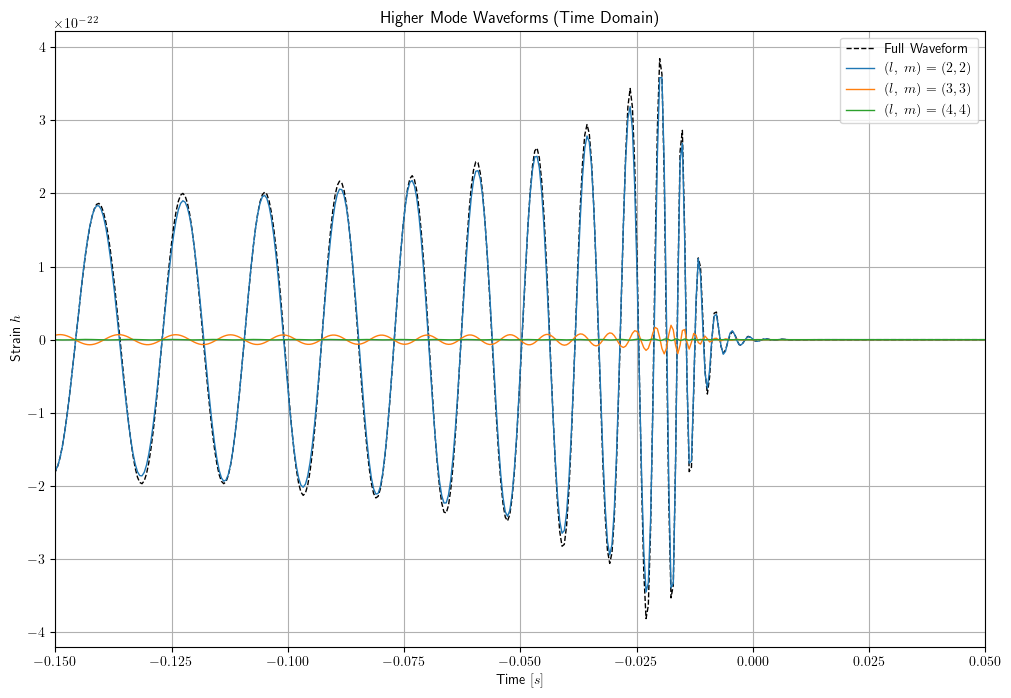

In [6]:

fig, ax = plt.subplots(figsize=(12, 8))
for idx, mode in enumerate(mode_array):
    if mode is None:
        ax.plot(htf_H1.sample_times, htf_H1, 'k--', linewidth=1, label='Full Waveform')
    else:
        ax.plot(ht_H1[f"{mode}"].sample_times, ht_H1[f"{mode}"], linewidth=1, label="$(l,\ m) = \ $" + '  '.join([f"$({l}, {m})$" for l, m in mode]))
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Strain $h$')
ax.set_xlim(injection_parameters['geocent_time']-0.15, injection_parameters['geocent_time']+0.05)
ax.legend()
ax.grid(True)
plt.title('Higher Mode Waveforms (Time Domain)')
plt.show()
plt.close()

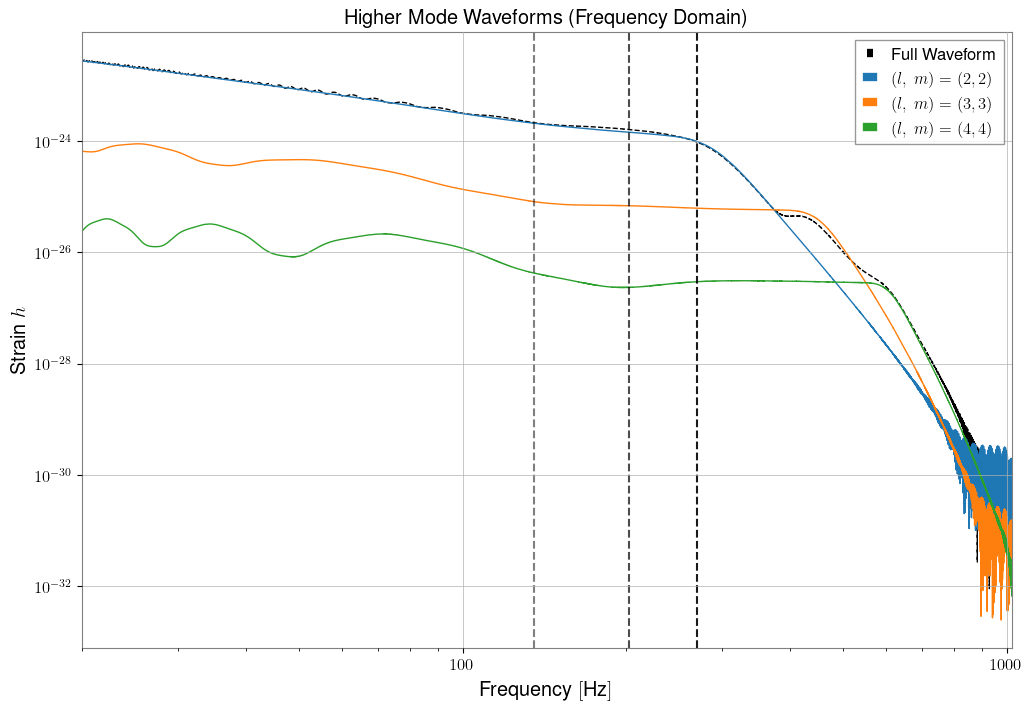

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
hf_H1, hf_L1, hf_V1 = {}, {}, {}
for idx, mode in enumerate(mode_array):
    if mode is None:
        hff_H1, hff_L1, hff_V1 = htf_H1.to_frequencyseries(), htf_L1.to_frequencyseries(), htf_V1.to_frequencyseries()
        ax.loglog(hff_H1.sample_frequencies, np.abs(hff_H1), 'k--', linewidth=1, label='Full Waveform')
    else:      
        hf_H1[f"{mode}"], hf_L1[f"{mode}"], hf_V1[f"{mode}"] = ht_H1[f"{mode}"].to_frequencyseries(), ht_L1[f"{mode}"].to_frequencyseries(), ht_V1[f"{mode}"].to_frequencyseries()
        ax.loglog(hf_H1[f"{mode}"].sample_frequencies, np.abs(hf_H1[f"{mode}"]), linewidth=1, label="$(l,\ m) = \ $" + '  '.join([f"$({l}, {m})$" for l, m in mode]))
ax.set_xlabel('Frequency $[$Hz$]$')
ax.set_ylabel('Strain $h$')
ax.set_xlim(20, 1024)
ax.legend()
ax.grid(True)
plt.title('Higher Mode Waveforms (Frequency Domain)')
plt.axvline(ff_isco, color='k', linestyle='--', alpha=.5)
plt.axvline(3/2*ff_isco, color='k', linestyle='--', alpha=.7)
plt.axvline(4/2*ff_isco, color='k', linestyle='--', alpha=.9)
plt.show()
plt.close()